## Import Library

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, roc_curve, roc_auc_score)
from sklearn.feature_selection import VarianceThreshold

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "data.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "uciml/breast-cancer-wisconsin-data",
  file_path,
)

print("First 5 records:\n", df.head())

First 5 records:
          id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area

## Preprocess Data

In [3]:
# Data is already loaded with kagglehub
# Let's explore it

# Basic info
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())

# Check for missing values
print("\nMissing values:", df.isnull().sum().sum())

# Check target distribution
if 'diagnosis' in df.columns:
    print("\nDiagnosis distribution:")
    print(df['diagnosis'].value_counts())
    print(df['diagnosis'].value_counts(normalize=True).round(3))

Dataset shape: (569, 33)

Column names: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Missing values: 569

Diagnosis distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64
diagnosis
B    0.627
M    0.373
Name: proportion, dtype: float64


In [4]:
# Check which columns have missing values
missing_cols = df.columns[df.isnull().any()].tolist()
print("Columns with missing values:", missing_cols)

# Check how many NaN values in each column with missing data
for col in missing_cols:
    print(f"{col}: {df[col].isna().sum()} missing values")

# Drop only the completely empty column (Unnamed: 32)
if 'Unnamed: 32' in df.columns:
    df = df.drop('Unnamed: 32', axis=1)

# Verify shape after dropping empty column
print("New dataset shape:", df.shape)

# Verify no more missing values
print("Missing values remaining:", df.isnull().sum().sum())

Columns with missing values: ['Unnamed: 32']
Unnamed: 32: 569 missing values
New dataset shape: (569, 32)
Missing values remaining: 0


In [6]:
# Drop ID column if it exists
if 'id' in df.columns:
    df = df.drop('id', axis=1)
elif 'ID' in df.columns:
    df = df.drop('ID', axis=1)

# Convert diagnosis to binary (M=1, B=0)
if 'diagnosis' in df.columns:
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Split features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Check for constant or near-constant features
selector = VarianceThreshold(threshold=1e-8)
X_filtered = selector.fit_transform(X)

# Get number of removed features
n_removed = X.shape[1] - X_filtered.shape[1]
if n_removed > 0:
    print(f"Removed {n_removed} constant or near-constant features")
    
    # If you need the feature names that were kept
    kept_features = X.columns[selector.get_support()].tolist()
    
    # Create filtered DataFrame with feature names
    X = X[kept_features]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")

Training set shape: (455, 30)
Testing set shape: (114, 30)


## Data Visualization

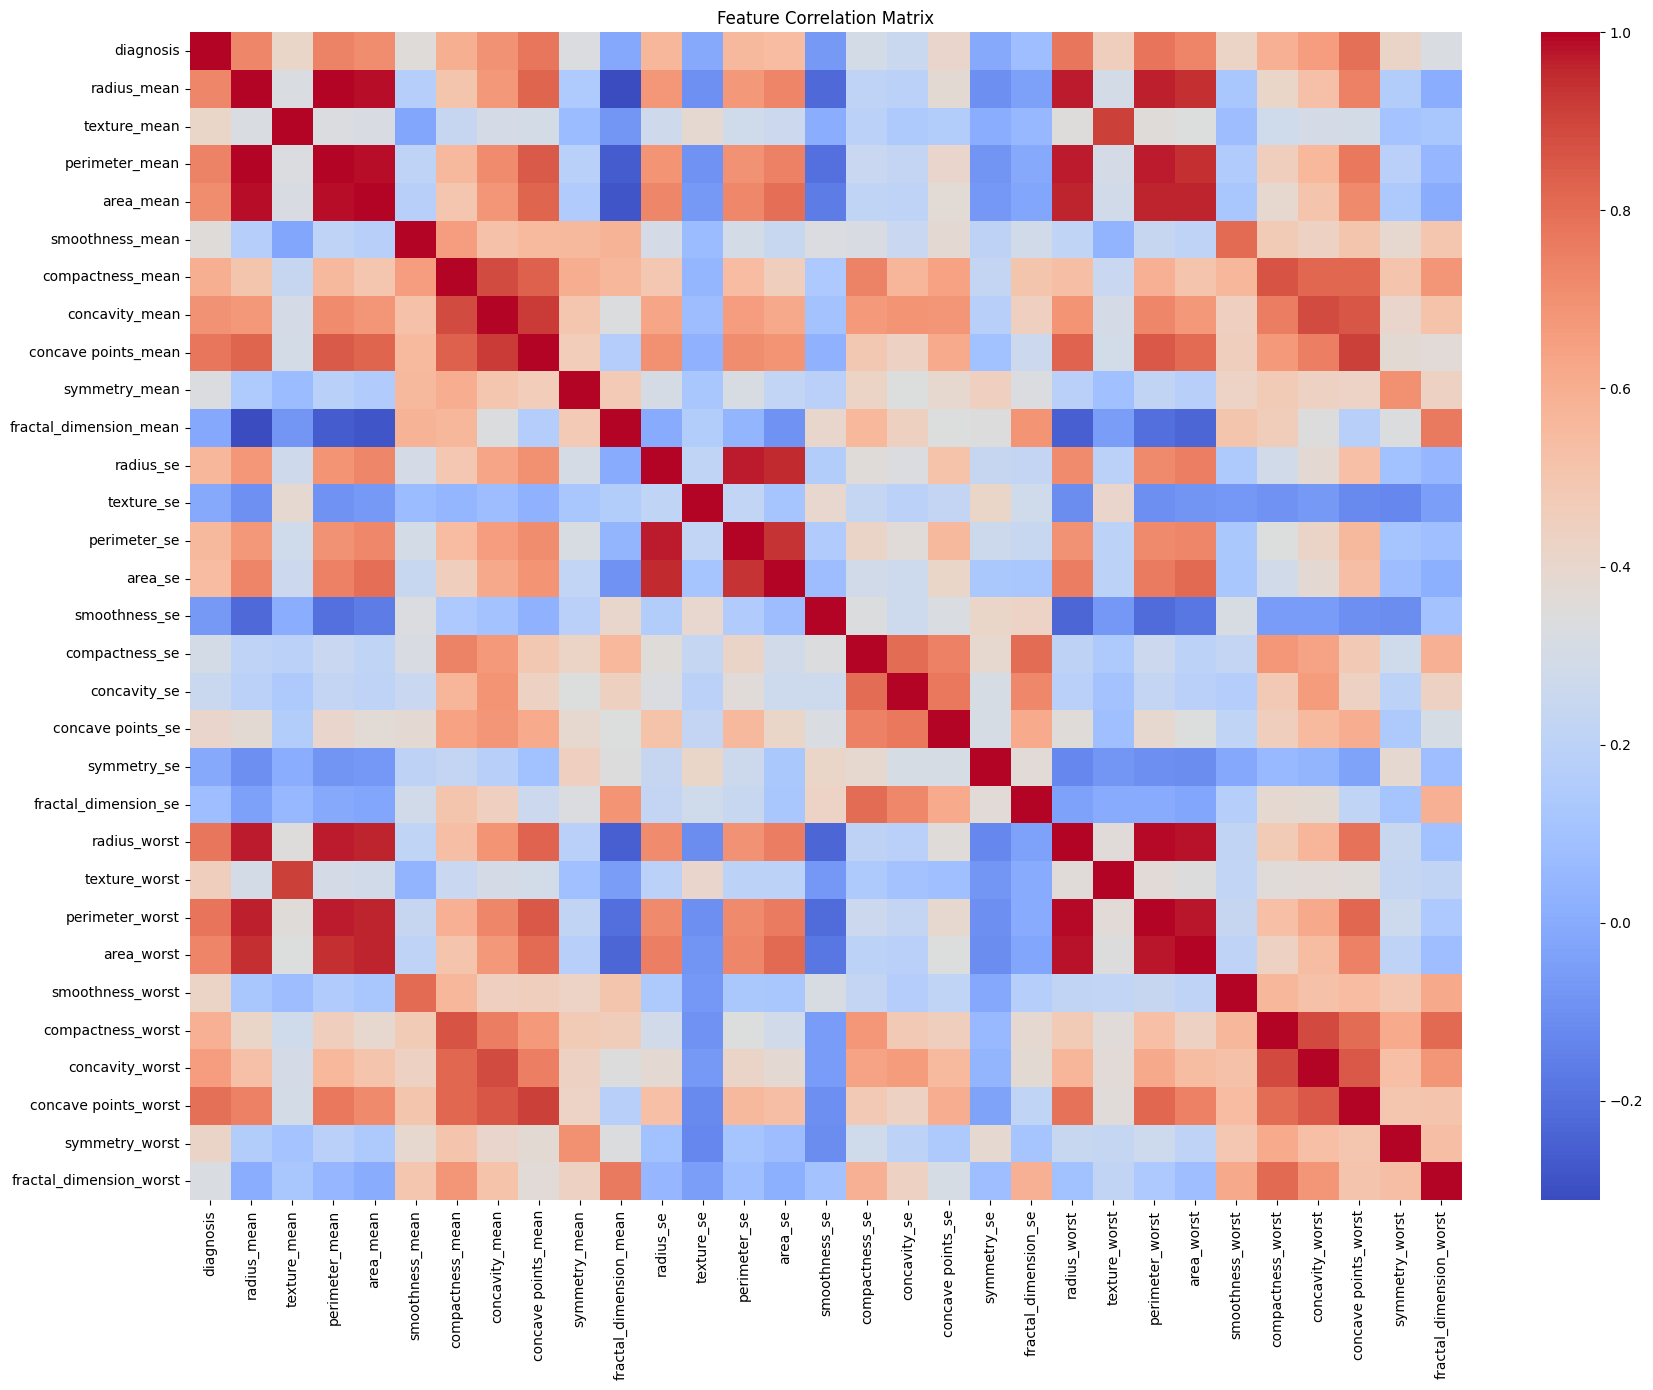

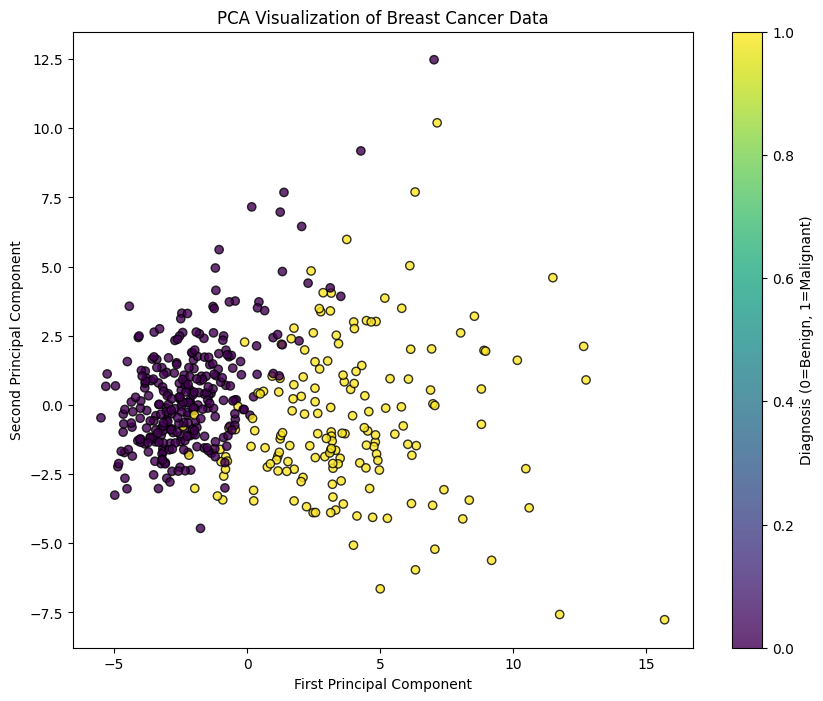

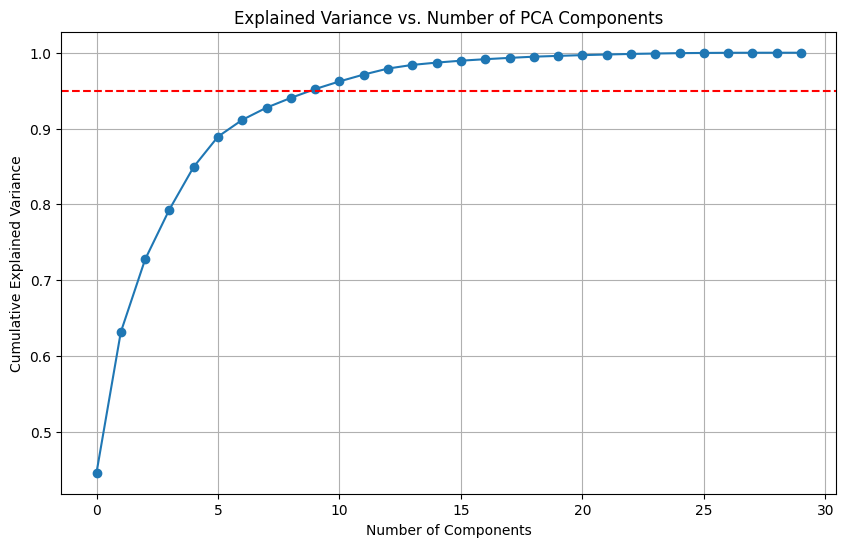

In [7]:
# Feature correlation heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# PCA visualization to see separability
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', 
            alpha=0.8, edgecolors='k')
plt.title('PCA Visualization of Breast Cancer Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Diagnosis (0=Benign, 1=Malignant)')
plt.show()

# Explained variance by PCA components
pca_full = PCA()
pca_full.fit(X_train_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of PCA Components')
plt.show()

## Baseline


==== Experiment 1: Baseline Model ====
Accuracy: 0.9649
ROC AUC: 0.9960

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



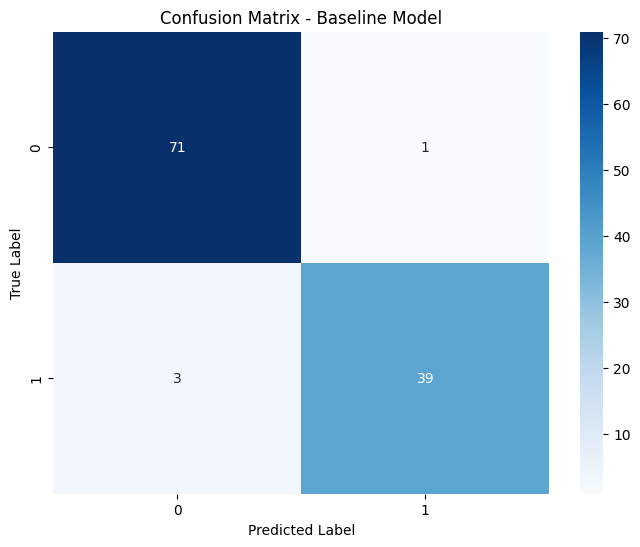

In [8]:
# Experiment 1: Baseline - No dimensionality reduction, no regularization
print("\n==== Experiment 1: Baseline Model ====")
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_model.predict(X_test_scaled)
y_prob_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate baseline model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_auc = roc_auc_score(y_test, y_prob_baseline)

print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"ROC AUC: {baseline_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Dimensionality Reduction with PCA


==== Experiment 2: PCA Model ====
Original features: 30
PCA features (95% variance): 10
Accuracy: 0.9737
ROC AUC: 0.9970

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



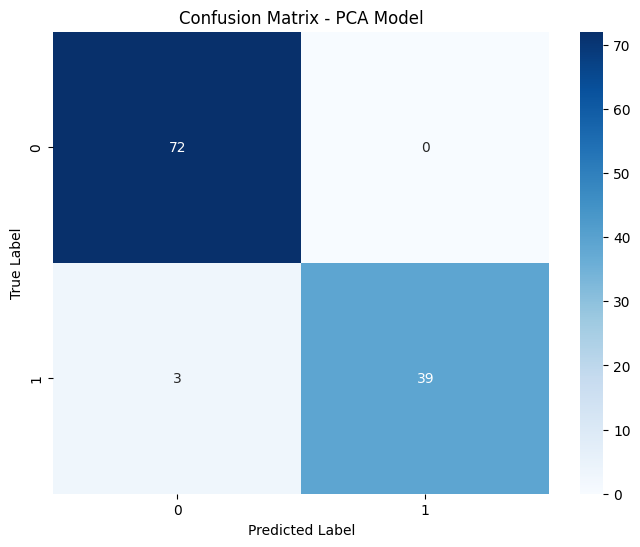

In [10]:
# Experiment 2: With Dimensionality Reduction (PCA)
print("\n==== Experiment 2: PCA Model ====")

# Find optimal number of components that explain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA features (95% variance): {X_train_pca.shape[1]}")

# Train model with PCA features
pca_model = LogisticRegression(random_state=42, max_iter=1000)
pca_model.fit(X_train_pca, y_train)

y_pred_pca = pca_model.predict(X_test_pca)
y_prob_pca = pca_model.predict_proba(X_test_pca)[:, 1]

# Evaluate PCA model
pca_accuracy = accuracy_score(y_test, y_pred_pca)
pca_auc = roc_auc_score(y_test, y_prob_pca)

print(f"Accuracy: {pca_accuracy:.4f}")
print(f"ROC AUC: {pca_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - PCA Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Dimensionality Reduction and Regularization


==== Experiment 3: PCA + Regularization Model ====
Best regularization parameter (C): 0.1
Accuracy: 0.9825
ROC AUC: 0.9980

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



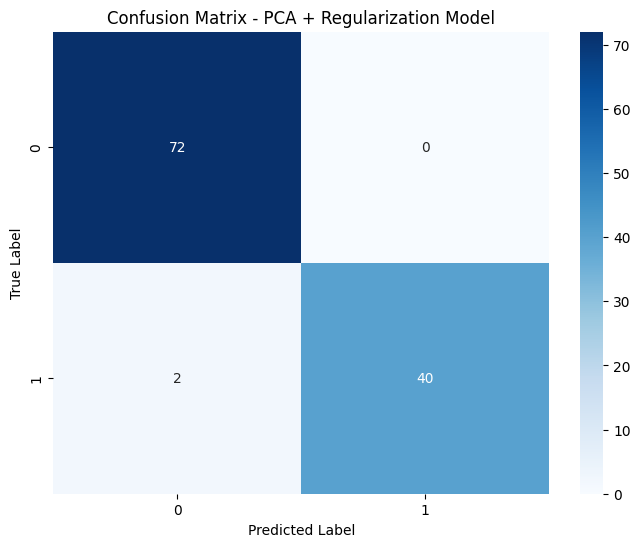

In [11]:
# Experiment 3: With Dimensionality Reduction and Regularization
print("\n==== Experiment 3: PCA + Regularization Model ====")

# Grid search to find optimal regularization parameter
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    LogisticRegression(penalty='l2', random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='roc_auc'
)
grid_search.fit(X_train_pca, y_train)

best_C = grid_search.best_params_['C']
print(f"Best regularization parameter (C): {best_C}")

# Train model with PCA features and regularization
pca_reg_model = LogisticRegression(C=best_C, penalty='l2', random_state=42, max_iter=1000)
pca_reg_model.fit(X_train_pca, y_train)

y_pred_pca_reg = pca_reg_model.predict(X_test_pca)
y_prob_pca_reg = pca_reg_model.predict_proba(X_test_pca)[:, 1]

# Evaluate PCA+Regularization model
pca_reg_accuracy = accuracy_score(y_test, y_pred_pca_reg)
pca_reg_auc = roc_auc_score(y_test, y_prob_pca_reg)

print(f"Accuracy: {pca_reg_accuracy:.4f}")
print(f"ROC AUC: {pca_reg_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca_reg))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_pca_reg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - PCA + Regularization Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Compare All Models


==== Model Comparison ====
                  Model  Accuracy   ROC AUC  Features
0              Baseline  0.964912  0.996032        30
1                   PCA  0.973684  0.997024        10
2  PCA + Regularization  0.982456  0.998016        10


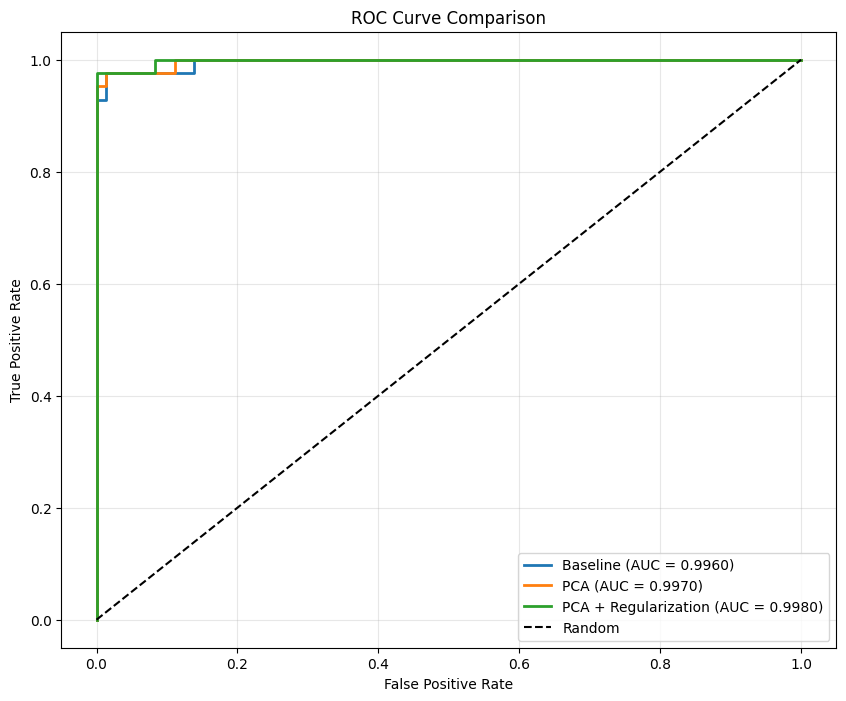

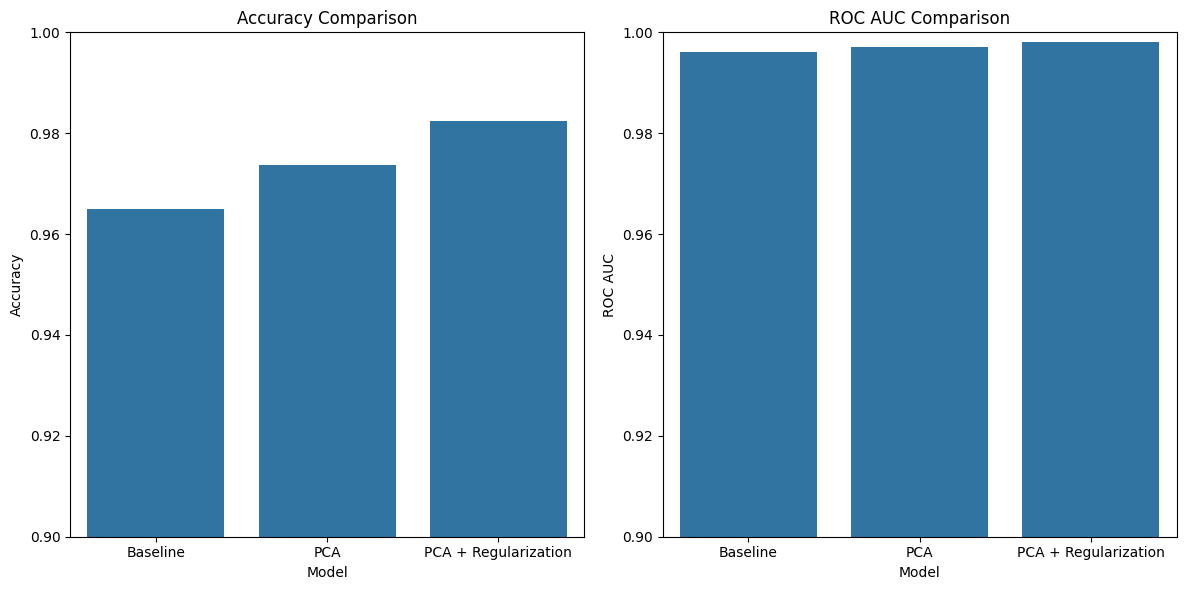

In [19]:
# Compare performance of all models
results = pd.DataFrame({
    'Model': ['Baseline', 'PCA', 'PCA + Regularization'],
    'Accuracy': [baseline_accuracy, pca_accuracy, pca_reg_accuracy],
    'ROC AUC': [baseline_auc, pca_auc, pca_reg_auc],
    'Features': [X_train_scaled.shape[1], X_train_pca.shape[1], X_train_pca.shape[1]]
})

print("\n==== Model Comparison ====")
print(results)

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Plot for Baseline model
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_baseline)
plt.plot(fpr_base, tpr_base, 
         label=f'Baseline (AUC = {baseline_auc:.4f})', linewidth=2)

# Plot for PCA model
fpr_pca, tpr_pca, _ = roc_curve(y_test, y_prob_pca)
plt.plot(fpr_pca, tpr_pca, 
         label=f'PCA (AUC = {pca_auc:.4f})', linewidth=2)

# Plot for PCA + Regularization model
fpr_pca_reg, tpr_pca_reg, _ = roc_curve(y_test, y_prob_pca_reg)
plt.plot(fpr_pca_reg, tpr_pca_reg, 
         label=f'PCA + Regularization (AUC = {pca_reg_auc:.4f})', linewidth=2)

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Plot accuracy comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Accuracy Comparison')
plt.ylim(0.9, 1.0)  # Adjust as needed based on results

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='ROC AUC', data=results)
plt.title('ROC AUC Comparison')
plt.ylim(0.9, 1.0)  # Adjust as needed based on results

plt.tight_layout()
plt.show()

## Conclusion

In [20]:
# Draw conclusions
print("\n==== Conclusion ====")

# Determine the best model
best_model_idx = results['ROC AUC'].idxmax()
best_model = results.iloc[best_model_idx]['Model']
print(f"Best performing model: {best_model}")

# Effect of dimensionality reduction
pca_effect = pca_auc - baseline_auc
print("\nEffect of dimensionality reduction:")
if pca_effect > 0:
    print(f"- Improved performance by {pca_effect:.4f} AUC while reducing features by "
          f"{X_train_scaled.shape[1] - X_train_pca.shape[1]} ({X_train_pca.shape[1]} vs {X_train_scaled.shape[1]})")
else:
    print(f"- Reduced performance by {-pca_effect:.4f} AUC while reducing features by "
          f"{X_train_scaled.shape[1] - X_train_pca.shape[1]} ({X_train_pca.shape[1]} vs {X_train_scaled.shape[1]})")

# Effect of regularization
reg_effect = pca_reg_auc - pca_auc
print("\nEffect of regularization:")
if reg_effect > 0:
    print(f"- Further improved performance by {reg_effect:.4f} AUC")
    print(f"- Optimal regularization strength (C): {best_C}")
else:
    print(f"- Did not improve performance (difference: {reg_effect:.4f} AUC)")
    print(f"- Selected regularization strength (C): {best_C}")

print("\nKey insights:")
print("1. Feature dimensionality: The dataset has many features (30), many of which are correlated.")
print("2. PCA effectiveness: PCA reduced dimensions while maintaining critical information for classification.")
print("3. Regularization impact: L2 regularization helped control model complexity and enhance generalization.")

print("\nThis analysis demonstrates how dimensionality reduction and regularization techniques")
print("can be applied to optimize machine learning models for breast cancer classification.")


==== Conclusion ====
Best performing model: PCA + Regularization

Effect of dimensionality reduction:
- Improved performance by 0.0010 AUC while reducing features by 20 (10 vs 30)

Effect of regularization:
- Further improved performance by 0.0010 AUC
- Optimal regularization strength (C): 0.1

Key insights:
1. Feature dimensionality: The dataset has many features (30), many of which are correlated.
2. PCA effectiveness: PCA reduced dimensions while maintaining critical information for classification.
3. Regularization impact: L2 regularization helped control model complexity and enhance generalization.

This analysis demonstrates how dimensionality reduction and regularization techniques
can be applied to optimize machine learning models for breast cancer classification.
